#Node2Vec

In [1]:
import os

print(os.getcwd())

c:\Users\Usuario\Challenge-Reproducibilidad


In [2]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import networkx as nx

# Cargar el grafo desde el archivo
G = nx.read_weighted_edgelist('moreno_lesmis/out.moreno_lesmis_lesmis', 
                     comments='%',
                     create_using=nx.Graph())

# Cantidad de nodos y aristas en el grafo
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")

# Ver un resumen del grafo
print("Nodos:", list(G.nodes))    
print("Aristas:", list(G.edges))  

Número de nodos: 77
Número de aristas: 254
Nodos: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '44', '45', '49', '50', '52', '56', '59', '65', '69', '70', '71', '72', '73', '17', '18', '19', '20', '21', '22', '23', '31', '42', '43', '51', '40', '41', '76', '55', '46', '53', '58', '63', '47', '48', '60', '61', '62', '64', '66', '67', '74', '75', '77', '57', '54', '68']
Aristas: [('1', '2'), ('2', '3'), ('2', '4'), ('2', '5'), ('2', '6'), ('2', '7'), ('2', '8'), ('2', '9'), ('2', '10'), ('2', '11'), ('3', '4'), ('3', '11'), ('4', '11'), ('11', '12'), ('11', '13'), ('11', '14'), ('11', '15'), ('11', '16'), ('11', '24'), ('11', '25'), ('11', '26'), ('11', '27'), ('11', '28'), ('11', '29'), ('11', '30'), ('11', '32'), ('11', '33'), ('11', '34'), ('11', '35'), ('11', '36'), ('11', '37'), ('11', '38'), ('11', '39'), ('11', '44'), ('11', '45'), ('11', '49'), ('11

In [4]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


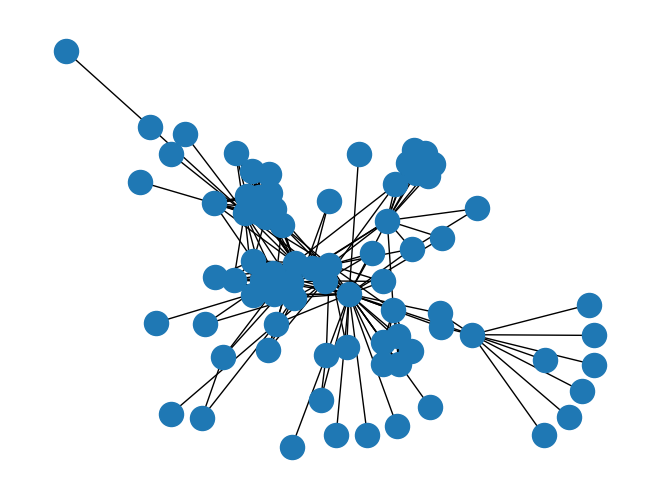

In [5]:
import matplotlib
nx.draw(G)

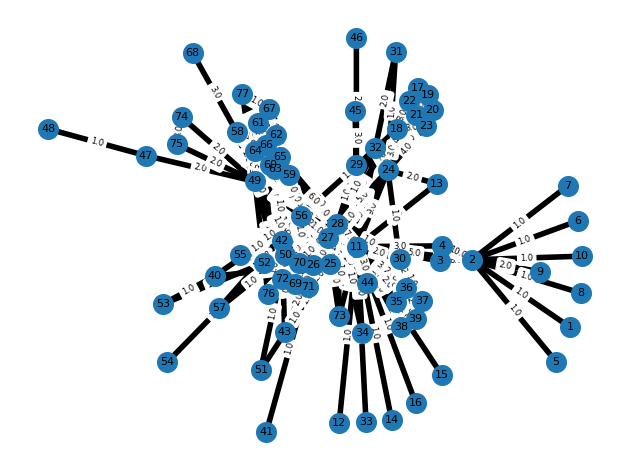

In [6]:
# Visualizemos el grafo con sus pesos
import matplotlib.pyplot as plt

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=10)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

ax = plt.gca()
ax.margins(0.02)
plt.axis("off")
plt.tight_layout()
plt.show()

In [60]:
#Implementacion del First Order Random Walk
def random_walk_FO(graph, start_node, walk_length):
    import random
    walk = [start_node]
    current_node = start_node
    
    for _ in range(walk_length):
        neighbors = [n for n in G.neighbors(current_node)] #Listamos todos los vecinos del nodo
        if not neighbors:
            break

        total_weight = 0
        individual_weights = []
        for i in neighbors:
            total_weight = total_weight + G.get_edge_data(current_node,i)['weight'] #Calculamos la suma de los pesos de los vecinos
            individual_weights.append(G.get_edge_data(current_node,i)['weight']) #Guardamos los pesos de cada arista en una lista

        probs = [w / total_weight for w in individual_weights] #Normalizamos las probabilidades

        current_node = random.choices(neighbors,weights=probs, k=1)[0] #Hacemos la decisión random, pero teniendo en cuenta las probabilidades
        walk.append(current_node)
    
    return walk

In [61]:
walk = random_walk_FO(G,"2",10)
print(walk)

['2', '11', '52', '50', '52', '50', '56', '50', '56', '27', '44']


In [110]:
#Implementacion del First Order Random Walk
def random_walk_SO(graph, start_node, walk_length, q, p):
    import random
    walk = [start_node]
    current_node = start_node
    previous_node = start_node
    
    for _ in range(walk_length):
        neighbors = [n for n in G.neighbors(current_node)] #Listamos todos los vecinos del nodo
        if not neighbors:
            break

        total_weight = 0
        individual_weights = []
        for i in neighbors:
            #Calculamos el alpha para controlar el retorno y el in-out del camino
            d = nx.shortest_path_length(G,source=previous_node,target=i)
            if d == 0:
                alpha = 1/p
            elif d == 1:
                alpha = 1
            elif d == 2:
                alpha = 1/q
            
            total_weight = total_weight + alpha*G.get_edge_data(current_node,i)['weight'] #Calculamos la suma de los pesos de los vecinos con el factor alpha
            individual_weights.append(alpha*G.get_edge_data(current_node,i)['weight']) #Guardamos los pesos de cada arista en una lista con el factor alpha

        probs = [w / total_weight for w in individual_weights] #Normalizamos las probabilidades
        previous_node = current_node
        current_node = random.choices(neighbors,weights=probs, k=1)[0] #Hacemos la decisión random, pero teniendo en cuenta las probabilidades
        walk.append(current_node)

    return walk

In [111]:
walk = random_walk_SO(G,"2",10,0.5,0.5)
print(walk)

['2', '4', '3', '2', '3', '11', '32', '11', '25', '51', '25']
